In [1]:
import os

import numpy as np
import scipy as sp
from scipy import misc, stats
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
#import plotly.plotly as py
import seaborn as sns
from pandas import DataFrame, Series
import warnings
warnings.filterwarnings('ignore')


%matplotlib inline

In [3]:

MAIN_TAG = 'bw'
DIRNAME_TAGS = 'D:/tags'
DIRNAME_IMAGES = 'D:/mirflickr'

COLOR = {'red': 0,
         'green': 1,
         'blue': 2}

In [4]:
from os import listdir
from matplotlib import image
import random
# load all images in a directory
np.random.RandomState(6)
random_indexes = np.random.choice(range(25000), 250)
loaded_images = list()
image_names = list()
for i in range(250):
	# load image
	randName = random_indexes[i]
	image_names.append(randName)
	filename = 'im' + str(randName) + '.jpg'
	img_data = image.imread('D:/mirflickr/' + filename)
	# store loaded image
	loaded_images.append(img_data)
	print('> loaded %s %s' % (filename, img_data.shape))

> loaded im12794.jpg (500, 500, 3)
> loaded im16293.jpg (434, 500, 3)
> loaded im16660.jpg (405, 500, 3)
> loaded im1508.jpg (400, 500, 3)
> loaded im20292.jpg (279, 500, 3)
> loaded im23203.jpg (375, 500, 3)
> loaded im20084.jpg (333, 500, 3)
> loaded im15708.jpg (375, 500, 3)
> loaded im22815.jpg (500, 290, 3)
> loaded im23574.jpg (500, 333, 3)
> loaded im7.jpg (500, 333, 3)
> loaded im8268.jpg (375, 500, 3)
> loaded im14228.jpg (375, 500, 3)
> loaded im15739.jpg (500, 399, 3)
> loaded im17956.jpg (188, 500, 3)
> loaded im5894.jpg (500, 481, 3)
> loaded im12569.jpg (333, 500, 3)
> loaded im9155.jpg (333, 500, 3)
> loaded im20508.jpg (500, 375, 3)
> loaded im12805.jpg (500, 333, 3)
> loaded im20196.jpg (500, 332, 3)
> loaded im8600.jpg (376, 500, 3)
> loaded im23842.jpg (375, 500, 3)
> loaded im12891.jpg (500, 466, 3)
> loaded im5565.jpg (333, 500, 3)
> loaded im20351.jpg (500, 500, 3)
> loaded im6762.jpg (375, 500, 3)
> loaded im932.jpg (333, 500, 3)
> loaded im5950.jpg (500, 333, 3)

In [5]:
len(image_names)

250

In [6]:
import codecs

Y = pd.Series()
for name in image_names:
    with codecs.open(os.path.join(DIRNAME_TAGS, 'tags%d.txt' % (name,)), "r", "utf_8_sig") as file:
        set_tags = set(tag.strip() for tag in file.readlines())
        #print('tags%d.txt' % (name,), '  ',set_tags)
        Y.at[name] = int(MAIN_TAG in set_tags)
Y = pd.DataFrame(Y, columns=['target'])

In [7]:
Y['target'].value_counts()

0    238
1     12
Name: target, dtype: int64

In [8]:
Y.head()

,target
12794,0
16293,0
16660,0
1508,0
20292,0


In [9]:
data_static = DataFrame()
num = 0
d = []
for image_name in image_names:
    image = np.array(Image.open(os.path.join(DIRNAME_IMAGES, 'im%d.jpg' % (image_name))))
    data = []
    for name, num in COLOR.items():
        a = image[:, :, num].ravel()
        data.extend([np.mean(a), np.var(a), sp.stats.skew(a), sp.stats.kurtosis(a)])
    d.append([image_name, *data])
    

data_static = pd.DataFrame.from_records(d)
data_static = data_static.rename(columns={0: 'name'}).set_index('name')

In [10]:
data_static.head()

,1,2,3,4,5,6,7,8,9,10,11,12
name,,,,,,,,,,,,
12794,72.238444,2679.877156,0.608164,0.324441,64.310748,2314.199960,0.839043,0.934329,54.413860,1802.993540,1.351030,2.934094
16293,133.897811,5650.957516,-0.250211,-1.092087,106.032166,3207.120938,-0.322296,-0.916808,104.843286,2851.004192,-0.397816,-0.723642
16660,120.236109,4409.250435,0.231712,-0.850808,126.233373,5738.013982,0.028637,-1.268823,109.022390,5307.746807,0.470193,-0.890168
1508,60.445375,3504.049606,0.922458,0.473668,54.523785,2841.602484,0.984354,0.913604,45.497615,2077.387904,1.080990,1.527014
20292,115.530509,4592.637342,0.399302,-0.874973,90.762115,3812.946472,0.848816,-0.137744,98.170258,3639.083148,0.780530,-0.240696


In [11]:
data_static.shape

(250, 12)

In [12]:
import itertools

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix

In [13]:
N = 12

In [14]:
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, round(cm[i, j], 3),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

font = {'size' : 15}

plt.rc('font', **font)

In [15]:
X = data_static.copy()

df = Y.join(X, how='inner')
df = df.drop_duplicates()

y = df['target']
X = df.drop('target', axis=1)

Normalized confusion matrix
[[0.99230231 0.00769769]
 [1.         0.        ]]


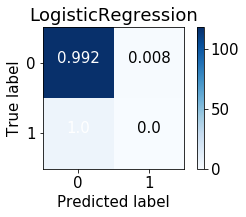

Normalized confusion matrix
[[0. 1.]
 [0. 1.]]


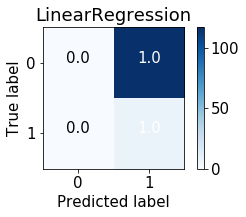

Normalized confusion matrix
[[1. 0.]
 [1. 0.]]


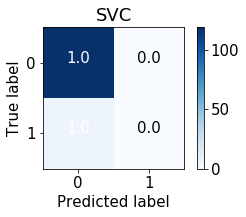

In [16]:
for c in (LogisticRegression, LinearRegression, SVC):
    cls = c()
    cnf_matrix = []
    for i in range(N):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)
        cls.fit(X_train, y_train)
        y_predict = cls.predict(X_test)
        cnf_matrix.append(confusion_matrix(y_test, y_predict.astype(bool).astype(int)))
    cnf_matrix = np.mean(np.array(cnf_matrix), axis=0)
    plt.figure(figsize=(4, 3))
    plot_confusion_matrix(cnf_matrix, classes=['0', '1'],
                          title=c.__name__)
    plt.savefig("static_" + c.__name__ + ".png")
    plt.show()

Normalized confusion matrix
[[0.99790649 0.00209351]
 [1.         0.        ]]


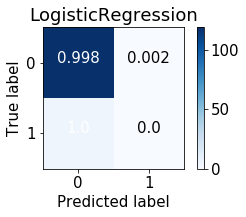

[[119.16666667   0.25      ]
 [  5.58333333   0.        ]]
Normalized confusion matrix
[[9.99299720e-01 7.00280112e-04]
 [1.00000000e+00 0.00000000e+00]]


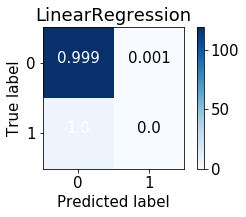

[[1.18916667e+02 8.33333333e-02]
 [6.00000000e+00 0.00000000e+00]]
Normalized confusion matrix
[[0.9979021 0.0020979]
 [1.        0.       ]]


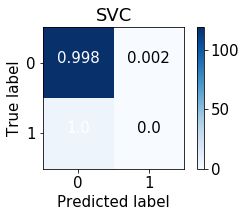

[[118.91666667   0.25      ]
 [  5.83333333   0.        ]]


In [17]:
for c in (LogisticRegression, LinearRegression, SVC):
    cls = LinearRegression(n_jobs=-1)
    cnf_matrix = []
    for i in range(N):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)
        cls.fit(X_train, y_train)
        y_predict = cls.predict(X_test).astype(int)
        #print(y_predict)
   
        cnf_matrix.append(confusion_matrix(y_test, y_predict.astype(bool).astype(int))) # .astype(int)
    #print(confusion_matrix(y_test, y_predict.astype(int)))
    cnf_matrix = np.mean(np.array(cnf_matrix), axis=0)
    plt.figure(figsize=(4, 3))
    plot_confusion_matrix(cnf_matrix, classes=['0', '1'],
                              title=c.__name__)
    plt.savefig("spam" + c.__name__ + ".png")
    plt.show()
    print(cnf_matrix)

Normalized confusion matrix
[[0.99154334 0.00845666]
 [0.98765432 0.01234568]]


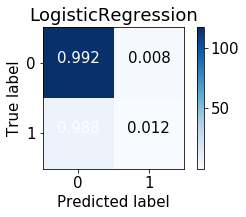

Normalized confusion matrix
[[0. 1.]
 [0. 1.]]


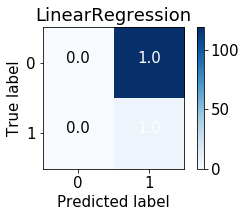

Normalized confusion matrix
[[0.921875   0.078125  ]
 [0.61538462 0.38461538]]


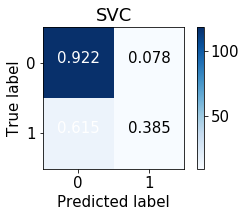

In [18]:
for c in (LogisticRegression, LinearRegression, SVC):
    cnf_matrix = []
    for i in range(N):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)
        cls = c()
        cls.fit(X_train, y_train)
        y_predict = cls.predict(X_test)
        cnf_matrix.append(confusion_matrix(y_test, y_predict.astype(bool).astype(int)))
    #print(confusion_matrix(y_test, y_predict.astype(int)))
    cnf_matrix = np.mean(np.array(cnf_matrix), axis=0)
    plt.figure(figsize=(4, 3))
    plot_confusion_matrix(cnf_matrix, classes=['0', '1'],
                              title=c.__name__)
    plt.savefig("ccpev_" + c.__name__ + ".png")
    plt.show()
    #print(cnf_matrix)